# CS-EJ3311 - Deep Learning with Python, 09.09.2020-18.12.2020
## Round 4 - Data Augmentaion 

S. Abdurakhmanova, B. Karki, J.P. Bartaula and A. Jung

Aalto University (Espoo, Finland)  
fitech.io (Finland)

As a rule of thumb, the number of labeled datapoints used for the training of ANN should be at least as large as the number of tunable parameters (weights, bias terms) of ANN. Since typical ANN structures involve millions of tunable parameters, we often have too little data points in the training set. 

One powerful approach to train ANN on relatively small training sets is **data augmentation**. The idea behind data augmentation is to enrich or augment the original training dataset by simple variations of the training samples. Consider a deep learning method that aims at classifying an image as either "cat" or "dog". 

To obtain a "cat vs. dog" classifier we could train a deep neural network on some cat images and some dog images (the labeled training data). The idea of data augmentation is to **artificially** augment the training set by creating **synthetic** data points. For example, by rotating a training image. A rotated image of a cat is still a cat image. Moreover, a shifted (translated) cat image is also still a cat image. The same applies to dog images. A rotated or shifted dog image is still showing a dog. 

One method to implement data augmentation is via the concept of **data generators**. A data generator is somewhat like a programming interface that allows to separate the code of the training algorithm (e.g., stochastic gradient descent) and the data storage system. This is very convenient for deep learning methods as the data can be stored in vastly different systems, ranging from a standard file system on a hard-disk all the way to a cloud computing environment. 

## Learning goals

- use data generators to train ANNs on large datasets. 
- understand the basic idea of data augmentation. 
- implement data augmentation using data generators in Python.  

## Recommended Reading

-   [Chapter 5.2](https://livebook.manning.com/book/deep-learning-with-python/chapter-5/71) of "Deep Learning with Python" by F. Chollet. 


## Additional Material (Optional!)

- [Corey Schafer — Python Tutorial: Generators — How to use them and the benefits you receive](https://www.youtube.com/watch?v=bD05uGo_sVI)
- [ImageDataGenerator – flow_from_directory method](https://theailearner.com/2019/07/06/imagedatagenerator-flow_from_directory-method/)
- [ImageDataGenerator – flow_from_dataframe method](https://theailearner.com/2019/07/06/imagedatagenerator-flow_from_dataframe-method/)
- [ImageDataGenerator – flow method](https://theailearner.com/2019/07/06/imagedatagenerator-flow-method/)

In [25]:
# import Python packages and libraries

# provides functionality to train neural network
import tensorflow as tf

# provides mathematical functions to operate on arrays and matrices
import numpy as np

# library to interact with operating system
import os

# library for generating plots
import matplotlib.pyplot as plt

In [ ]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

# set the path 
import sys
sys.path.append('/content/drive/My Drive/dlpython/source/Round4')

## Data

We will use data in the form of images which belong to two different classes "cats" and "dogs". Binary label $y$ is assigned to each image and can take values either $y=0$ or $y=1$. 

The images (data points) are stored in the "cats_and_dogs_small" directory and the directory has following structure:

In [ ]:
plt.figure(figsize=(12,6))
img=plt.imread('/content/drive/My Drive/dlpython/source/Round4/dir.png')
plt.imshow(img)
plt.axis('off') 
plt.show()

The main directory contains three subdirectories: 'train', 'test', and 'validation'. These three directories contain, respectively, the training, validation and test images. The images in these three directories are stored in two subdirectories named "cats" and "dogs", which contain images belonging to corresponding class labels.

Below we will define the paths to the directories and display how many images there are in each directory.\
`os.path.join()` function concatenates various path components with directory separator (‘/’). For example, the command `os.path.join('../../data/cats_and_dogs_small', 'train')` will return path `'../../data/cats_and_dogs_small/train'`

In [26]:
# The path to the dataset
base_dir = '/content/drive/My Drive/dlpython/data/cats_and_dogs_small'

# Directories for training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with training cats and dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cats and dogs pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with test cats and dogs pictures
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

print('training cat images:', len(os.listdir(train_cats_dir)))
print('training dog images:', len(os.listdir(train_dogs_dir)))

print('validation cat images:', len(os.listdir(validation_cats_dir)))
print('validation dog images:', len(os.listdir(validation_dogs_dir)))

print('test cat images:', len(os.listdir(test_cats_dir)))
print('test dog images:', len(os.listdir(test_dogs_dir)))

training cat images: 998
training dog images: 1000
validation cat images: 500
validation dog images: 497
test cat images: 500
test dog images: 500


## Data generators

Those who are familiar with `scikit-learn` Python package, will remember that most of machine learning (ML) methods provided by the package have the same usage pattern. First, we load the training data into numpy arrays that store the features and labels of all training data points. These numpy arrays are then fed to `.fit()` function that implements the learning algorithm for a particular ML model. After the model has been trained, we apply it to the new data points, using `.predict()` function, in order to obtain predictions for the labels of new data points. 

In contrast, deep learning methods often involve extremely large training data sets which cannot be stored entirely in a numpy array (we would run out of RAM on a desktop computer). Therefore, often Deep learning methods use a sequential access to training data. This approach ties in nicely with the working principle of stochastic gradient descent (SGD). In particular, we divide dataset into smaller sets or parts called **batches** and only store single batch in the working memory (e.g. as numpy arrays). The total number of samples present in a single batch is called **batch size**. 

After loading a new batch of data, we update the ANN parameters (weights and bias) using one iteration of an SGD variant. We repeat this batch-wise optimization until we have read in each data point of the dataset. A sequence of batches that together cover the entire dataset is called an **epoch**. Note that the batch size is a hyperparameter of the resulting deep learning method. The choice of hyperparameter is often based on manual tuning ("trial and error") to minimize the validation loss. 

The sequential batch-wise access to data is implemented in `Keras` class  
[ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). This class also provides methods for [data augmentation](https://d2l.ai/chapter_computer-vision/image-augmentation.html). We will discuss image augmentation in details, but first, let us show how to use the `ImageDataGenerator` for batch-wise access to our cats-and-dogs dataset.  

## Loading Data with `ImageDataGenerator`
 
The class `ImageDataGenerator` provided by the package `Keras` implements the batch-wise (sequential) access to large sets of image files which are stored locally (hard disk). 
This class has following three methods to read the images either from directories or from numpy array. 

- `.flow()` takes data and label numpy arrays & generates batches of data

- `.flow_from_dataframe()` takes the dataframe and the path to a directory & generates batches of data

- `.flow_from_directory()` takes the path to a directory & generates batches of data



What are the [Python generators](https://wiki.python.org/moin/Generators) in general? Python generator is a function which behaves like an iterator, i.e. it can be used in a for-loop. It looks like a normal function except that it contains `yield` expression (instead of `return` ) for producing a series of values usable in a for-loop or that can be retrieved one at a time with the `next()` function [link](https://docs.python.org/3/glossary.html#term-generator). \
Look at the example of a simple Python generator function, which generates infinite sequence of numbers:

In [27]:
# define a Python generator function, which can create an infinite sequence of numbers
def sequence_generator():   
    number = 0
    while True:
        # `yield` statement pauses the function, saves all its states
        # and later continues from there on successive calls
        yield number
        number += 1

numbers = []
for number in sequence_generator():
    numbers.append(number)
    if number>9: # we need to include `break` statement, otherwise the for-loop will iterate infinitely
        break
numbers

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

We can access generated values of Python generator by using `next()` function.

In [28]:
# create generator object
a = sequence_generator()
# display the type of an object 
print("The variable `a` is ", type(a))

# display values generated by generator object by using function `next()`
next(a), next(a), next(a)

The variable `a` is  <class 'generator'>


(0, 1, 2)

Now, let's look in a more detail how to use Keras ImageDataGenerator class to read-in images in batches from a directory. First, create a Python generator:\
`train_datagen = ImageDataGenerator()`

Apply `flow_from_directory()` method on generator and set batch size and directory from which the images will be loaded:\
`train_generator = train_datagen.flow_from_directory(batch_size=32, directory='../data/train')`

Finally, we can use our generator during the model training. The batches of data (size=32) will be one-by-one fed to the neural network:\
`history = model.fit(train_generator, epochs=5)`

Below we will compile all steps together and will train a model with `ImageDataGenerator()`:

In [29]:
# import ImageDataGenerator class
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create ImageDataGenerator object for training data
train_datagen = ImageDataGenerator(rescale = 1./255)
# create ImageDataGenerator object for validation data
val_datagen = ImageDataGenerator(rescale=1./255) 
# create ImageDataGenerator object for test data
test_datagen = ImageDataGenerator(rescale=1./255) 

# print the type of the ImageDataGenerator object 
print("The object `train_datagen` is a", type(train_datagen))

The object `train_datagen` is a <class 'tensorflow.python.keras.preprocessing.image.ImageDataGenerator'>


Now, when we've created the generator, we need to choose how to access the data (images). As we discussed above, we don't want to load all our data into RAM at once, but rather access data one batch at a time. To do that, we will use `ImageDataGenerator.flow_from_directory()` method ([docs here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)) to generate the image batches from given directory. This method takes the path to the target directory as an input and generates batches of numpy arrays from images. In addition, it automatically assignes lables to the data based on directory structure (each subdirectory will be given a label). E.g. if directory '../../data/cats_and_dogs_small/train' contains 2 subdirectories "cats" and "dogs", this methods will assigned numeric labels to the image, dependent on image location.


We will use following arguments with the `.flow_from_directory()` method ([docs here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)).

- `batch_size` - number of images per each batch

- `directory` - path to our images

- `target size`  - the dimensions to which all images will be resized

- `class_mode` - commonly used class modes are `binary` for binary labels and `categorical` for numpy array of one-hot encoded labels. 

In [30]:
# create generator function for training dataset
train_generator = train_datagen.flow_from_directory(batch_size=32,
                                                    directory=train_dir,
                                                    target_size=(150, 150),
                                                    class_mode='binary')
# create generator function for validation dataset
val_generator = val_datagen.flow_from_directory(batch_size=32,
                                                directory=validation_dir,
                                                target_size=(150, 150),
                                                class_mode='binary')

# create generator function for testing dataset
test_generator = test_datagen.flow_from_directory(batch_size=32,
                                                 directory=test_dir,
                                                 target_size=(150, 150),
                                                 class_mode='binary')

Found 1997 images belonging to 2 classes.
Found 995 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
# print the type of the ImageDataGenerator object 
print("The object `train_generator` is a", type(train_generator))

The object `train_generator` is a <class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>


As with any Python generator we can access and inspect the values created by generator by using `next()` function. The batch (images with labels) returned by generator will have shapes `(32, 150, 150, 3)` and ` (32,)` respectively, as we set `batch_size=32` and `target_size=(150, 150)`. 

In [32]:
# retrieve first values
image_batch1, label_batch1 = next(train_generator)

# display numpay arrays shape
image_batch1.shape, label_batch1.shape

((32, 150, 150, 3), (32,))

Now, when we've created generator objects, we can easily access any image and its label. In the code snippet below we will plot some images and their labels from training dataset.

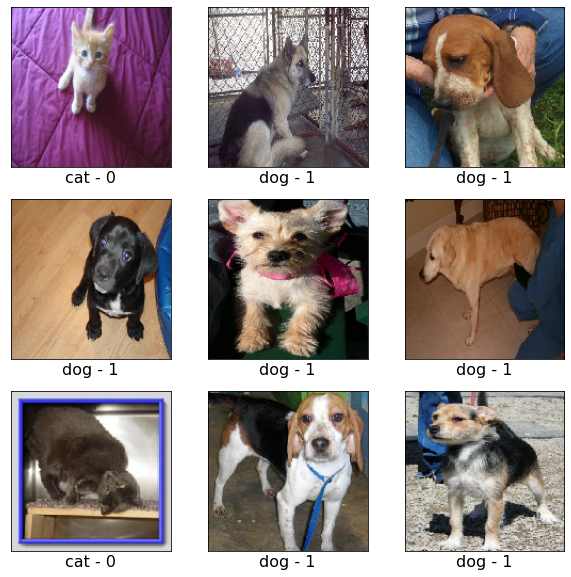

In [34]:
# create figure object
fig = plt.figure(1,figsize=(10,10))

# list containing x axis labels
class_name = ['cat', 'dog']

# plot first 9 images from the training dataset
for i in range(9):
    # create an empty subplot
    plt.subplot(3,3,i+1)
    # read the image file 
    image = plt.imshow(image_batch1[i])
    
    # format axes 
    plt.xticks([])  # remove x axis ticks        
    plt.yticks([])  # remove y axis ticks
    
    # set the image x axis label
    label = int(label_batch1[i])
    plt.xlabel(class_name[label]+" - "+str(label), fontsize = 16)
    
plt.show()

### Wrap-up:  data generators:

- RAM needed for training on big datasets may not be enough. This can fixed by using data generators and feeding the dataset to the ANN in small batches.

- `ImageDataGenerator` Keras class provides methods for creating such data generators 
- `ImageDataGenerator` data generator supports loading the images from directory and can automatically convert the images to numpy arrays

## CNN training without Data augmentaion

So far we have been focused on the data used in our deep learning application. Now we will define the hypothesis space by defining the ANN structure for representing maps from pixels (features) to predicted label $\hat{y}$. In other words, our choice of ANN structure defines predictor map. We also specify the loss function used to evaluate the quality of a given predictor map (choice for ANN weights and bias). 

We will use a ANN consisting of the following layers:
    
Input → 3* (Conv → Pool) → Flatten → Dense → Dense 

In [53]:
# define the model architecture 
model = tf.keras.models.Sequential([   
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # flatten the results to feed to Dense layers
    tf.keras.layers.Flatten(),
    
    # 128 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)            

In [54]:
# compile the model
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

Before starting training, let's recap parameter **epochs** in `.fit method()`. 
**Epochs** parameter defines the number of times the model is trained over the ENTIRE dataset. 

Suppose, there are 1000 training samples. We divide the training samples into 5 batches of size 200 samples. We train the model using 200 samples, i.e first batch (from 1st to 200th) from the training dataset. Next, we take the second 200 samples (from 201st to 300th) and trains the network again. We can keep doing training until we have propagated all samples in training set through the network. When we train the model once, using ENTIRE dataset, we call it one epoch. 

**NB!** In earlier version of Keras, `.fit_generator()` method is used to train the model when using data generator as input. In the current version `.fit_generator()` function  IS DEPRECATED and will be removed in a future version.  Now, `.fit()` method supports generator as an input. 

In [55]:
%%time

# train the CNN ~40 min on CPU, ~10 min on Colab GPU
history = model.fit(train_generator, 
                    epochs=50, 
                    validation_data = val_generator)

Train for 63 steps, validate for 32 steps
Epoch 1/50
63/63 [==============================] - 43s 685ms/step - loss: 0.6973 - accuracy: 0.5388 - val_loss: 0.6649 - val_accuracy: 0.6291
Epoch 2/50
63/63 [==============================] - 47s 750ms/step - loss: 0.6466 - accuracy: 0.6370 - val_loss: 0.6509 - val_accuracy: 0.6000
Epoch 3/50
63/63 [==============================] - 43s 687ms/step - loss: 0.6051 - accuracy: 0.6785 - val_loss: 0.6186 - val_accuracy: 0.6342
Epoch 4/50
63/63 [==============================] - 44s 704ms/step - loss: 0.5671 - accuracy: 0.7056 - val_loss: 0.5916 - val_accuracy: 0.6854
Epoch 5/50
63/63 [==============================] - 42s 666ms/step - loss: 0.5322 - accuracy: 0.7346 - val_loss: 0.5817 - val_accuracy: 0.6905
Epoch 6/50
63/63 [==============================] - 43s 681ms/step - loss: 0.5042 - accuracy: 0.7581 - val_loss: 0.5943 - val_accuracy: 0.6714
Epoch 7/50
63/63 [==============================] - 43s 678ms/step - loss: 0.4839 - accuracy: 0.7742

Now, we will plot the history of the training in the same way as in Round 2, but instead of writing and executing the same peice of code several times, we will import user defined finction `plot_history()` from  'plot_history.py' file. This file is stored in the same folder as the notebook and you can open and inspect the code, if you wish. The function takes `history` object as an input and outputs accuracy and loss plots. 

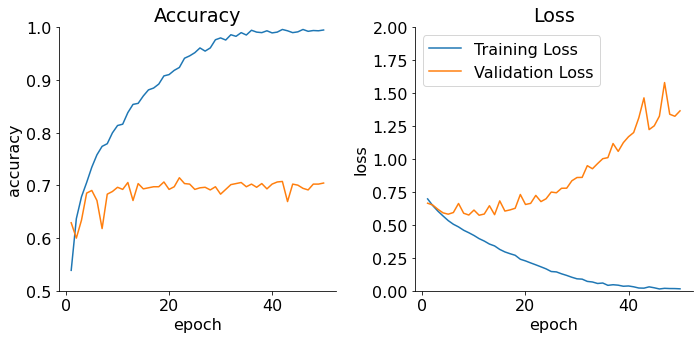

In [57]:
from plot_history import plot_history
plot_history(history)

In [58]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'The test set accuracy of model is {test_acc:.2f}')

32/32 [==============================] - 8s 241ms/step - loss: 1.3317 - accuracy: 0.7060
The test set accuracy of model is 0.71


With this model we reach accuracy of 0.70 on test set. From the accuracy and loss plots we can see that our model is overfitting immediately after the first epochs. \
If you will train the model longer (~300 epochs, ~1h on Colab GPU) you will see that the model will overfit for the most of the training time and validation and test accuracy will not improve above 0.70-0.73. 

In [ ]:
plt.figure(figsize=(20,8))
img=plt.imread('/content/drive/My Drive/dlpython/source/Round4/R4_1.png')
plt.imshow(img)
plt.axis('off') 
plt.show()

As we are training our model with relatively small training dataset (~2000 training images), it is not surprising to see overfitting happening. Below, we will try a technique to overcome the problem of overfitting when training with a small dataset (image augmentation). 

## CNN training with Data Augmentation

**[Data augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)** is a technique to create new training images by applying random image transformation like random rotation, shifts, shear and flips, etc. These random image transformation can be combined to make many variants of the original images and transformed images are fed to ANN. Potentially, data augmentation can prevent overfitting. 

Now, let's see some examples of image transformation. We will use `tf.image` [module](https://www.tensorflow.org/api_docs/python/tf/image) to modify the images.

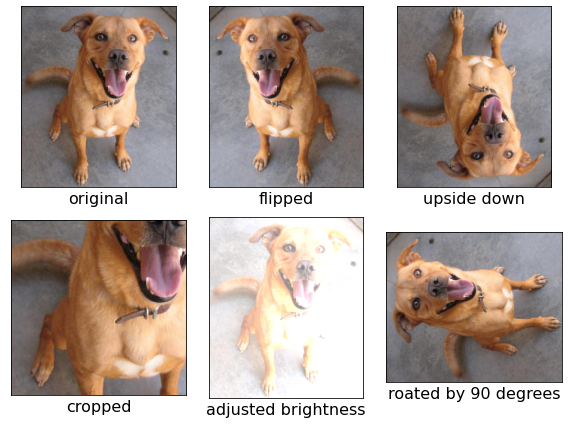

In [37]:
# load the image
image = plt.imread('/content/drive/My Drive/dlpython/source/Round4/dog.912.jpg')[:,:,:3]

# transform the image:

# flip horizontally
flip = tf.image.flip_left_right(image)
# flip upside-down
updown = tf.image.flip_up_down(image)
# crop area of the image
crop = tf.image.random_crop(image,(250,250,3))
# adjust brightness
brightness = tf.image.adjust_brightness(image, 0.5)
# rotate
rotate = tf.image.rot90(image)

# captions for different transformations 
label = ['original', 'flipped', 'upside down', 'cropped', 'adjusted brightness', 'roated by 90 degrees']

# list containing original image and its transformations 
transformations = [image, flip, updown, crop, brightness, rotate]

fig = plt.figure(1,figsize=(8,6))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(transformations[i])
    
    # format axes 
    plt.xticks([])  # remove x axis ticks        
    plt.yticks([])  # remove y axis ticks
    
    # set the image x axis label
    plt.xlabel(label[i], fontsize = 16)
    
fig.tight_layout()
plt.show()

You can see now, how easy it is to generate multiple images by just modifying one image.\
In Keras `ImageDataGenerator` data augmentation parameters can be set during generator instantiation, for example:

`train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=40, zoom_range=0.2, horizontal_flip=True)`

You can see that some modifications we apply to the images are set in ranges: e.g. `rotation_range=40` means that each image will be rotated by a degree randomly chosen from the range 0-40. The combination of these random transformations are applied to the images and as a result our model would never see the exact same picture twice. 

**Note**, that the validation and test data should not be augmented! We augment only the images used for the model training, but not for the model evaluation. Therefore, we will re-define generator for the training data, but will use validation and test data generators we defined earlier.

In [38]:
# import ImageDataGenerator class
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create ImageDataGenerator object for training data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

These are just a few of the options available (for more, see the [documentation](https://keras.io/preprocessing/image/)). Let's go over some parameters we set:

- `rescale` is a value by which we will multiply the data before any other processing. Our original images consist of RGB pixel values in the range 0-255, but such values would be too high for our models to process (given a typical learning rate), so we rescale to the range 0 and 1 by scaling with a 1/255. factor. Note, that `rescale` is normalization method, not image augmentation
- `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- `shear_range` is for randomly applying shearing transformations
- `zoom_range` is for randomly zooming inside pictures
- `horizontal_flip` is for randomly flipping half of the images horizontally; relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.


In [39]:
# create generator function for training dataset
train_generator = train_datagen.flow_from_directory(batch_size=32,
                                                    directory=train_dir,
                                                    target_size=(150, 150),
                                                    class_mode='binary')

Found 1997 images belonging to 2 classes.


Let's check how our augmented images looks like:

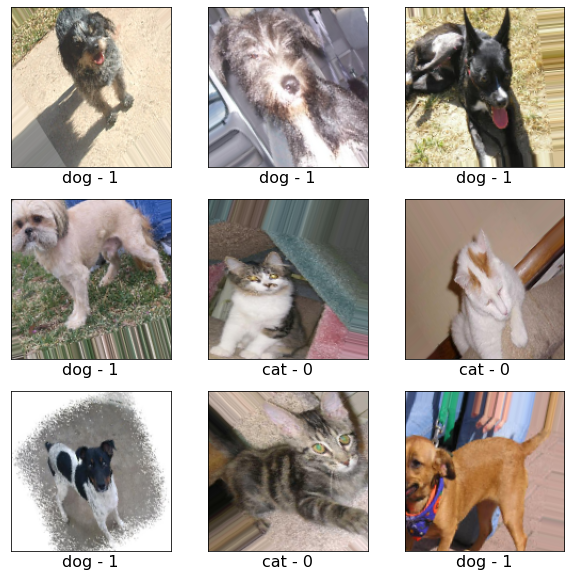

In [40]:
# retrieve first values
image_batch1, label_batch1 = next(train_generator)

# create figure object
fig = plt.figure(1,figsize=(10,10))

# list containing x axis labels
class_name = ['cat', 'dog']

# plot first 9 images from the training dataset
for i in range(9):
    # create an empty subplot
    plt.subplot(3,3,i+1)
    # read the image file 
    image = plt.imshow(image_batch1[i])
    
    # format axes 
    plt.xticks([])  # remove x axis ticks        
    plt.yticks([])  # remove y axis ticks
    
    # set the image x axis label
    label = int(label_batch1[i])
    plt.xlabel(class_name[label]+" - "+str(label), fontsize = 16)
    
plt.show()

We will train CNN model with same architecture as before, but using the new generator for training dataset, which will apply random transformations to the training images. 

In [78]:
# define the model architecture 
model = tf.keras.models.Sequential([   
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # flatten the results to feed to DNN
    tf.keras.layers.Flatten(),
    
    # 128 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

# compile the model
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 36992)            

In [79]:
%%time

# train the CNN ~40 min on CPU, ~15 min on Colab GPU
history = model.fit(train_generator, 
                    epochs=50, 
                    validation_data = val_generator)

Train for 63 steps, validate for 32 steps
Epoch 1/50
63/63 [==============================] - 49s 781ms/step - loss: 0.6965 - accuracy: 0.5168 - val_loss: 0.6811 - val_accuracy: 0.5015
Epoch 2/50
63/63 [==============================] - 48s 756ms/step - loss: 0.6746 - accuracy: 0.5653 - val_loss: 0.6541 - val_accuracy: 0.6171
Epoch 3/50
63/63 [==============================] - 48s 758ms/step - loss: 0.6558 - accuracy: 0.6064 - val_loss: 0.6413 - val_accuracy: 0.5910
Epoch 4/50
63/63 [==============================] - 48s 759ms/step - loss: 0.6445 - accuracy: 0.6299 - val_loss: 0.6348 - val_accuracy: 0.6030
Epoch 5/50
63/63 [==============================] - 48s 759ms/step - loss: 0.6348 - accuracy: 0.6324 - val_loss: 0.6407 - val_accuracy: 0.6211
Epoch 6/50
63/63 [==============================] - 48s 757ms/step - loss: 0.6211 - accuracy: 0.6460 - val_loss: 0.6025 - val_accuracy: 0.6553
Epoch 7/50
63/63 [==============================] - 48s 759ms/step - loss: 0.6186 - accuracy: 0.6475

Plot training result:

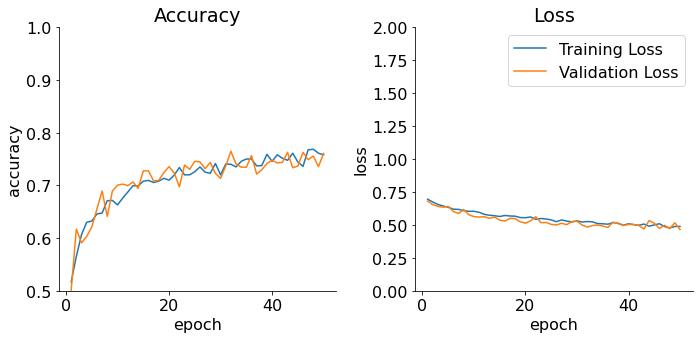

In [80]:
from plot_history import plot_history
plot_history(history)

In [81]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'The test set accuracy of model is {test_acc:.2f}')

32/32 [==============================] - 7s 213ms/step - loss: 0.5143 - accuracy: 0.7390
The test set accuracy of model is 0.74


We see that data augmentation improved the accuracy of the model predictions from 0.70 to around 0.74-0.76 on the validation and test sets.

If you will train the model longer (~300 epochs, ~1.5h on Colab GPU) you will see that the model will still overfit in last 50-100 epochs, but the validation and test accuracy will improve to about 0.80. Data augmentation can not fully prevent overfitting as the augmented images are still highly correlated with the original ones, thus amount of the new information added is less than, let's say, when adding new images.

In [ ]:
plt.figure(figsize=(20,8))
img=plt.imread('/content/drive/My Drive/dlpython/source/Round4/R4_2.png')
plt.imshow(img)
plt.axis('off') 
plt.show()

### Wrap-up image augmentation:
- Small dataset can lead to neural network overfitting. Image augmentation helps to prevent overfitting and improves model generalization
-  Keras `ImageDataGenerator` class has variety of image transformation methods
-  Keras `ImageDataGenerator` class generators of augmented images allow the creation of almost infinite number of transformed images
- although augmented images are very helpful in preventing overfitting, the modified images are still correlated

# Summary

In this notebook we've showed how to create a data generator with Keras `ImageDataGenerator()` and use it for training and validation of the CNN model. The data generator function creates small batches of data to sequentially feed these batches to neural network and train the model. Data generator is an effective way to train the model when you have large dataset and limited computation power. We covered one way of loading the image data from given directory with `.flow_from_directory()` method, but there are other methods to create batches of the data. We also learnt how we to use Keras `ImageDataGenerator` class to perform a real time data augmentation, which in turns helps to prevent an overfitting of the training data. 